In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [4]:
RelTimeDF

,NGA,RelTime,SPC1
0,Deccan,-2400,0.155157
1,Deccan,-2300,0.155157
2,Deccan,-2200,0.155157
3,Deccan,-2100,0.155157
4,Deccan,-2000,0.155157
...,...,...,...
766,Yemeni Coastal Plain,1000,0.801720
767,Yemeni Coastal Plain,1100,0.797062
768,Yemeni Coastal Plain,1200,0.958307
769,Yemeni Coastal Plain,1300,0.568928


In [5]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [6]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [7]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [8]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

n 596
y 103


In [9]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

succeeding (quasi)polity 364
relationship to preceding (quasi)polity 335


In [10]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [11]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [12]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

contination 1
cultural assimilation 25
replacement 1
population migration 13
suspected unknown 2
continunity 4
indigenous revolt 1
continuity 228
elite migration 40
Continuity 9
vassalage 1
not applicable 2
Continuation 1
continuation 7


In [13]:
Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

discontinuity 85
continuity 250


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
print(Relationships)

                      NGA    PolID               Longform.Name  Polity.Start  \
15      Big Island Hawaii  Hawaii2                   Hawaii II        1200.0   
18                Cahokia  USMisEW    Cahokia - Early Woodland        -600.0   
20                Cahokia  USMisMW   Cahokia - Middle Woodland        -150.0   
22                Cahokia  USMisRo   Cahokia - Late Woodland I         300.0   
23                Cahokia  USMisMu  Cahokia - Late Woodland II         450.0   
..                    ...      ...                         ...           ...   
849      Valley of Oaxaca  MxAlb3B     Monte Alban IIIB and IV         500.0   
852      Valley of Oaxaca  EsHabsb            Spanish Empire I        1469.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [15]:
PolRel.loc[PolRel["Dupl"] == "y"].iloc[51:100]

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
546,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
547,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
548,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
549,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
550,Paris Basin,TrRomDm,Roman Empire - Dominate,285.0,394.0,y,General variables,succeeding (quasi)polity,Western Roman Empire - Late Antiquity,NaN,NaN,NaN
551,Paris Basin,TrRomDm,Roman Empire - Dominate,285.0,394.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
581,Sogdiana,IrAchae,Achaemenid Empire,-550.0,-331.0,y,General variables,succeeding (quasi)polity,Macedonian Empire,NaN,NaN,NaN
582,Sogdiana,IrAchae,Achaemenid Empire,-550.0,-331.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
583,Sogdiana,IrSeleu,Seleucid Empire,-312.0,-63.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
584,Sogdiana,IrSeleu,Seleucid Empire,-312.0,-63.0,y,General variables,succeeding (quasi)polity,Parthian Empire I,NaN,NaN,NaN


In [16]:
for n in list(set(PolRel["NGA"])):
    print(PolRel.loc[PolRel["NGA"]==n])

         NGA    PolID           Longform.Name  Polity.Start  Polity.End Dupl  \
207  Iceland  IsCommw  Icelandic Commonwealth         930.0      1262.0    n   
208  Iceland  IsCommw  Icelandic Commonwealth         930.0      1262.0    n   
209  Iceland  NorKing       Kingdom of Norway        1262.0      1380.0    n   
210  Iceland  NorKing       Kingdom of Norway        1262.0      1380.0    n   

               Section                                 Variable  \
207  General variables  relationship to preceding (quasi)polity   
208  General variables                 succeeding (quasi)polity   
209  General variables  relationship to preceding (quasi)polity   
210  General variables                 succeeding (quasi)polity   

            Value.From  Value.To  Value.Date.From  Value.Date.To  
207         continuity       NaN              NaN            NaN  
208  Kingdom of Norway       NaN              NaN            NaN  
209         continuity       NaN              NaN            N

               NGA    PolID                   Longform.Name  Polity.Start  \
483  Orkhon Valley  MnXngnE                   Early Xiongnu       -1400.0   
484  Orkhon Valley  MnXngnM  Xiongnu Imperial Confederation        -209.0   
485  Orkhon Valley  MnXngnM  Xiongnu Imperial Confederation        -209.0   
486  Orkhon Valley  MnXngnL                    Late Xiongnu         -60.0   
487  Orkhon Valley  MnXngnL                    Late Xiongnu         -60.0   
488  Orkhon Valley  MnXianb           Xianbei Confederation         100.0   
489  Orkhon Valley  MnXianb           Xianbei Confederation         100.0   
490  Orkhon Valley  MnXianb           Xianbei Confederation         100.0   
491  Orkhon Valley  MnRourn                Rouran Khaganate         300.0   
492  Orkhon Valley  MnRourn                Rouran Khaganate         300.0   
493  Orkhon Valley  MnETurk          Eastern Turk Khaganate         583.0   
494  Orkhon Valley  MnETurk          Eastern Turk Khaganate         583.0   

154              continuity       NaN              NaN            NaN  
             NGA    PolID                   Longform.Name  Polity.Start  \
520  Paris Basin  FrBeakr                  Beaker Culture       -3200.0   
521  Paris Basin  FrBeakr                  Beaker Culture       -3200.0   
522  Paris Basin  FrBeakr                  Beaker Culture       -3200.0   
523  Paris Basin  FrAtlBA                Atlantic Complex       -2200.0   
524  Paris Basin  FrAtlBA                Atlantic Complex       -2200.0   
525  Paris Basin  FrHallA                  Hallstatt A-B1       -1000.0   
526  Paris Basin  FrHallA                  Hallstatt A-B1       -1000.0   
527  Paris Basin  FrHallB                  Hallstatt B2-3        -900.0   
528  Paris Basin  FrHallB                  Hallstatt B2-3        -900.0   
529  Paris Basin  FrHallC                     Hallstatt C        -700.0   
530  Paris Basin  FrHallC                     Hallstatt C        -700.0   
531  Paris Basin  FrHallD   

573            NaN  
              NGA    PolID                      Longform.Name  Polity.Start  \
180  Finger Lakes  UsIroqE  Haudenosaunee Confederacy - Early        1566.0   
181  Finger Lakes  UsIroqE  Haudenosaunee Confederacy - Early        1566.0   
182  Finger Lakes  UsIroqL   Haudenosaunee Confederacy - Late        1714.0   
183  Finger Lakes  UsIroqL   Haudenosaunee Confederacy - Late        1714.0   

     Polity.End Dupl            Section  \
180      1713.0    n  General variables   
181      1713.0    n  General variables   
182      1848.0    n  General variables   
183      1848.0    n  General variables   

                                    Variable                Value.From  \
180  relationship to preceding (quasi)polity                continuity   
181                 succeeding (quasi)polity      Iroquois Confederacy   
182                 succeeding (quasi)polity  United States of America   
183  relationship to preceding (quasi)polity                continuity 

        NGA    PolID          Longform.Name  Polity.Start  Polity.End Dupl  \
155  Deccan  InDecNL     Deccan - Neolithic       -2700.0     -1200.0    n   
156  Deccan  InDecIA      Deccan - Iron Age       -1200.0      -300.0    n   
157  Deccan  InDecIA      Deccan - Iron Age       -1200.0      -300.0    n   
158  Deccan  InMaury         Mauryan Empire        -324.0      -187.0    y   
159  Deccan  InMaury         Mauryan Empire        -324.0      -187.0    y   
160  Deccan  InDecKg  Post-Mauryan Kingdoms        -205.0      -101.0    n   
161  Deccan  InSataL      Satavahana Empire        -100.0       203.0    n   
162  Deccan  InKadam         Kadamba Empire         345.0       550.0    n   
163  Deccan  InKadam         Kadamba Empire         345.0       550.0    n   
164  Deccan  InChaBd    Chalukyas of Badami         543.0       753.0    n   
165  Deccan  InChaBd    Chalukyas of Badami         543.0       753.0    n   
166  Deccan  InRasht     Rashtrakuta Empire         753.0       

[69 rows x 12 columns]


In [17]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [18]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [19]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Deccan,Sogdiana,Ghanaian Coast,Konya Plain,Latium,Paris Basin,Orkhon Valley,Middle Yellow River Valley,Kansai,Yemeni Coastal Plain,Upper Egypt,Niger Inland Delta,Cambodian Basin,Susiana,Central Java,Iceland,Kachi Plain,Cuzco
0,T0,-300,-500,1800,-2000,-700,-200,500,-1800,400,400,-3100,1000,300,-3700,800,1300,-2500,1400


In [20]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [21]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


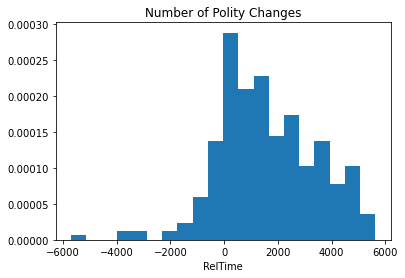

In [22]:
plt.hist(Relationships["Polity.End.Scaled"], bins =20, density = True)
plt.title("Number of Polity Changes")
plt.xlabel("RelTime")
plt.show()

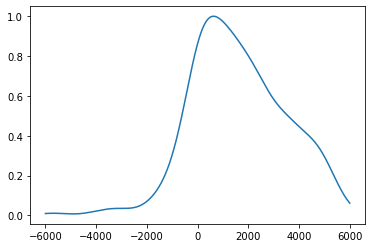

In [23]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)
plt.plot(time_range, KDE_t / max(KDE_t))
plt.show()

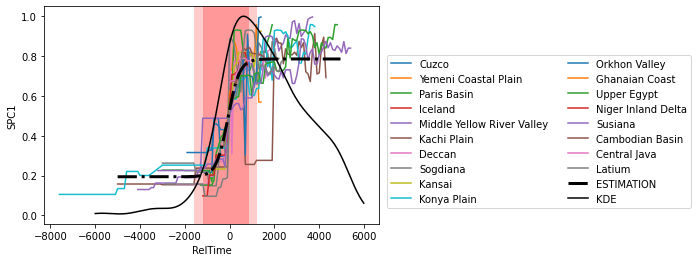

In [24]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [25]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [26]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [27]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

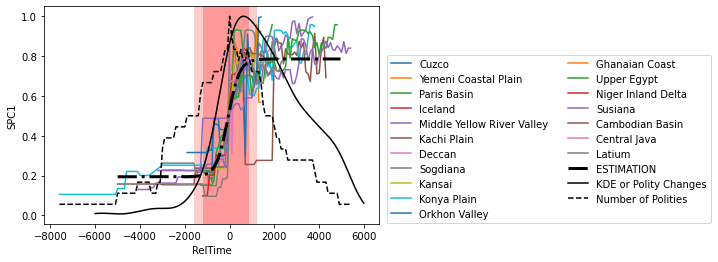

In [28]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

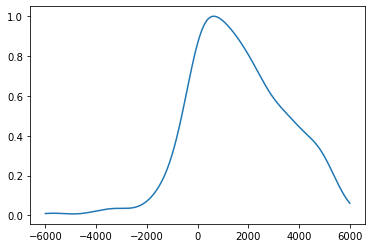

In [29]:
Changes_round = Relationships["Polity.End.Scaled"].round(-2)
KDE_round = gaussian_kde(Changes_round)
time_range = np.arange(-6000,6000,10)
kde_round = KDE_round(time_range)
plt.plot(time_range, kde_round / max(kde_round))
plt.show()

In [30]:
# take the rounded changes in polity
# and construct a frequency table
Changes_FrequencyTable = pd.DataFrame(columns = np.arange(T_min, T_max+100, 100))

for t in Changes_FrequencyTable.columns:
    Changes_FrequencyTable[int(t)] = sum(Changes_round==t)

print(Changes_FrequencyTable)


Empty DataFrame
Columns: [-7600, -7500, -7400, -7300, -7200, -7100, -7000, -6900, -6800, -6700, -6600, -6500, -6400, -6300, -6200, -6100, -6000, -5900, -5800, -5700, -5600, -5500, -5400, -5300, -5200, -5100, -5000, -4900, -4800, -4700, -4600, -4500, -4400, -4300, -4200, -4100, -4000, -3900, -3800, -3700, -3600, -3500, -3400, -3300, -3200, -3100, -3000, -2900, -2800, -2700, -2600, -2500, -2400, -2300, -2200, -2100, -2000, -1900, -1800, -1700, -1600, -1500, -1400, -1300, -1200, -1100, -1000, -900, -800, -700, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, ...]
Index: []

[0 rows x 131 columns]


In [31]:
Changes_FrequencyTable = pd.DataFrame( columns = ["RelTime", "NumberChanges", "NormedChanges"])

for t in np.arange(T_min, T_max+100, 100):
    Number_of_Polities = NumberPol["NumberPol"].loc[NumberPol["RelTime"]==t][0] # number of polities at time t
    Changes_FrequencyTable = pd.concat((Changes_FrequencyTable,
                                       pd.DataFrame(data={"RelTime": [t],
                                                         "NumberChanges": [sum(Changes_round==t)],
                                                         "NormedChanges": [sum(Changes_round==t) / Number_of_Polities]})))
    
print(Changes_FrequencyTable)

   RelTime NumberChanges  NormedChanges
0    -7600             0            0.0
0    -7500             0            0.0
0    -7400             0            0.0
0    -7300             0            0.0
0    -7200             0            0.0
..     ...           ...            ...
0     5000             4            4.0
0     5100             0            0.0
0     5200             3            3.0
0     5300             0            0.0
0     5400             2            2.0

[131 rows x 3 columns]


In [32]:
Changes_round

42      200.0
44      300.0
46      500.0
49      800.0
51      900.0
        ...  
830    4800.0
834    4900.0
858    1400.0
861    1400.0
862    1500.0
Name: Polity.End.Scaled, Length: 294, dtype: float64

In [33]:
Changes_FrequencyTable

,RelTime,NumberChanges,NormedChanges
0,-7600,0,0.0
0,-7500,0,0.0
0,-7400,0,0.0
0,-7300,0,0.0
0,-7200,0,0.0
...,...,...,...
0,5000,4,4.0
0,5100,0,0.0
0,5200,3,3.0
0,5300,0,0.0


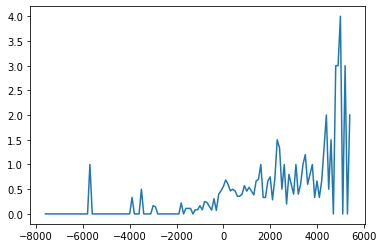

In [34]:
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NormedChanges"], label ="Normed")


[]

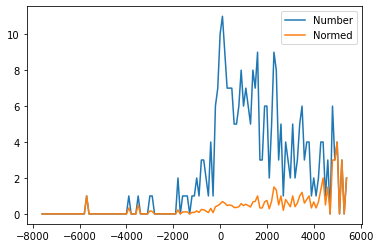

In [35]:
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NumberChanges"], label="Number")
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NormedChanges"], label ="Normed")
plt.legend()
plt.plot()

In [36]:
Changes_FrequencyTable

,RelTime,NumberChanges,NormedChanges
0,-7600,0,0.0
0,-7500,0,0.0
0,-7400,0,0.0
0,-7300,0,0.0
0,-7200,0,0.0
...,...,...,...
0,5000,4,4.0
0,5100,0,0.0
0,5200,3,3.0
0,5300,0,0.0


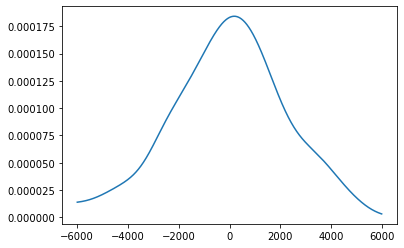

In [37]:
KDE_RelTime = gaussian_kde(RelTimeDF["RelTime"])
kde_reltime = gaussian_kde(RelTimeDF["RelTime"])
plt.plot(np.arange(-6000,6000,10), kde_reltime(np.arange(-6000,6000,10)))

In [38]:
def FT_to_Hist(df, Scale = 1):
    # Takes a frequency table
    # Scales the frequencies with Scale
    # takes the Gaussian floor function
    # and turns the frequency table into a list of events, e.g.
    # A with Frequency 2 and Scaling 2 is turned into [A, A, A, A]
    NP = df.to_numpy()
    Output = list()
    for i in range(df.shape[0]): # go through all lines
        freq = int(NP[i,1] * Scale)
        for j in range(freq): # append as often to the list as "Frequency * Scale"
            Output.append(NP[i,0])
    return(Output)

In [39]:
## Test
FT_to_Hist(pd.DataFrame(data={"Thing":["a", "b", "c"],
                             "Freq": [2, 0, 0.9]}),
          Scale = 2)

['a', 'a', 'a', 'a', 'c']

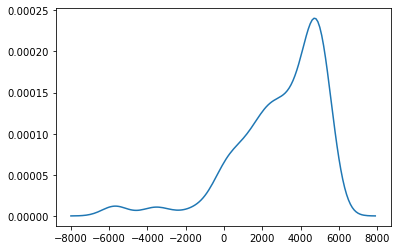

In [40]:
Normed_Changes_List = FT_to_Hist(Changes_FrequencyTable[["RelTime", "NormedChanges"]], 
                                 Scale = 10)
KDE_normed_changes = gaussian_kde(Normed_Changes_List)
yearrange = np.arange(-8000,8000,100)
kde_normed_changes = KDE_normed_changes(yearrange)
plt.plot(yearrange, kde_normed_changes)

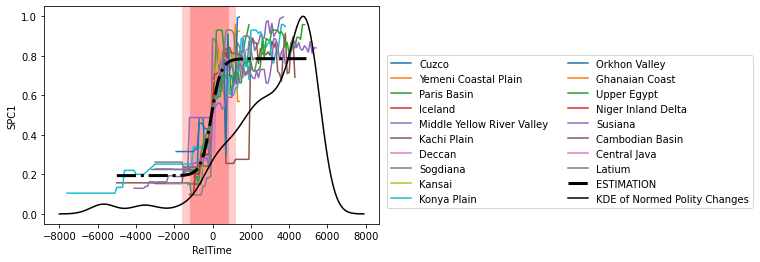

In [41]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(yearrange, kde_normed_changes / max(kde_normed_changes), 
         c="k", label="KDE of Normed Polity Changes")

#plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
#        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

In [42]:
Changes_FrequencyTable.to_numpy()[:,0]

array([-7600, -7500, -7400, -7300, -7200, -7100, -7000, -6900, -6800,
       -6700, -6600, -6500, -6400, -6300, -6200, -6100, -6000, -5900,
       -5800, -5700, -5600, -5500, -5400, -5300, -5200, -5100, -5000,
       -4900, -4800, -4700, -4600, -4500, -4400, -4300, -4200, -4100,
       -4000, -3900, -3800, -3700, -3600, -3500, -3400, -3300, -3200,
       -3100, -3000, -2900, -2800, -2700, -2600, -2500, -2400, -2300,
       -2200, -2100, -2000, -1900, -1800, -1700, -1600, -1500, -1400,
       -1300, -1200, -1100, -1000, -900, -800, -700, -600, -500, -400,
       -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900,
       1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
       2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100,
       3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200,
       4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300,
       5400], dtype=object)

In [43]:
Changes_FrequencyTable["NormedChanges"].loc[Changes_FrequencyTable["NormedChanges"]!=0]

0    1.000000
0    0.333333
0    0.500000
0    0.166667
0    0.142857
       ...   
0    3.000000
0    3.000000
0    4.000000
0    3.000000
0    2.000000
Name: NormedChanges, Length: 73, dtype: float64

In [44]:
for i in Changes_round:
    print(i,sum(Changes_round == i))

200.0 9
300.0 7
500.0 7
800.0 6
900.0 8
1100.0 7
1300.0 5
1500.0 7
1600.0 9
200.0 9
400.0 7
700.0 5
900.0 8
-1200.0 1
-900.0 1
-800.0 3
-800.0 3
-400.0 4
-400.0 4
-200.0 6
-200.0 6
0.0 10
100.0 11
100.0 11
100.0 11
300.0 7
0.0 10
100.0 11
800.0 6
1100.0 7
1300.0 5
1500.0 7
1600.0 9
1600.0 9
1900.0 6
2200.0 5
2100.0 2
-100.0 7
-100.0 7
100.0 11
-0.0 10
100.0 11
-3000.0 1
-1500.0 1
-700.0 3
0.0 10
400.0 7
4300.0 4
2000.0 6
2200.0 5
2300.0 9
2500.0 3
2800.0 4
3000.0 2
3100.0 5
3100.0 5
3200.0 2
3400.0 5
4000.0 2
4400.0 4
4300.0 4
-5700.0 1
-3900.0 1
-2900.0 1
-1600.0 1
-700.0 3
-200.0 6
100.0 11
300.0 7
800.0 6
900.0 8
1100.0 7
1200.0 6
1200.0 6
1500.0 7
-3500.0 1
-1000.0 2
0.0 10
0.0 10
300.0 7
600.0 5
800.0 6
1100.0 7
1300.0 5
1300.0 5
1700.0 3
1700.0 3
1900.0 6
1900.0 6
2300.0 9
2300.0 9
2300.0 9
2300.0 9
2300.0 9
2400.0 8
2400.0 8
2400.0 8
2400.0 8
2400.0 8
2600.0 5
2600.0 5
2900.0 3
3100.0 5
3300.0 3
3300.0 3
3300.0 3
3400.0 5
3500.0 6
3700.0 4
3800.0 4
3800.0 4
3900.0 1
-1100.0 1
-2

## Deal with the Continuity of Polities

In [45]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [46]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [47]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [48]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga):
    
    
    Output = RelTimeDF.loc[RelTimeDF["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [49]:
RelTimeDF

,NGA,RelTime,SPC1
0,Deccan,-2400,0.155157
1,Deccan,-2300,0.155157
2,Deccan,-2200,0.155157
3,Deccan,-2100,0.155157
4,Deccan,-2000,0.155157
...,...,...,...
766,Yemeni Coastal Plain,1000,0.801720
767,Yemeni Coastal Plain,1100,0.797062
768,Yemeni Coastal Plain,1200,0.958307
769,Yemeni Coastal Plain,1300,0.568928


In [50]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))

BPs        NGA  RelTime
138  Cuzco   -751.0
142  Cuzco   -401.0
145  Cuzco   -150.0
149  Cuzco    132.0
152  Cuzco    132.0
-150.0 132.0
       NGA  RelTime      SPC1
363  Cuzco     -100  0.374145
364  Cuzco        0  0.594646
365  Cuzco      100  0.602291
BPs        NGA  RelTime
138  Cuzco   -751.0
142  Cuzco   -401.0
145  Cuzco   -150.0
149  Cuzco    132.0
152  Cuzco    132.0
-150.0 132.0
BPs                       NGA  RelTime
862  Yemeni Coastal Plain   1520.0
-inf 1520.0
                      NGA  RelTime      SPC1
757  Yemeni Coastal Plain        0  0.729010
758  Yemeni Coastal Plain      100  0.729010
759  Yemeni Coastal Plain      200  0.874002
760  Yemeni Coastal Plain      300  0.841906
761  Yemeni Coastal Plain      500  0.686559
762  Yemeni Coastal Plain      600  0.686559
763  Yemeni Coastal Plain      700  0.802861
764  Yemeni Coastal Plain      800  0.839822
765  Yemeni Coastal Plain      900  0.801720
766  Yemeni Coastal Plain     1000  0.801720
767  Yemeni Coastal Plain

67  Central Java    718.0
-inf 718.0
BPs         NGA  RelTime
375  Latium    984.0
384  Latium   1604.0
-inf 984.0
        NGA  RelTime      SPC1
209  Latium    -2900  0.157375
210  Latium    -2800  0.157375
211  Latium    -2700  0.157375
212  Latium    -2600  0.157375
213  Latium    -2500  0.157375
214  Latium    -2400  0.157375
215  Latium    -2300  0.157375
216  Latium    -2200  0.157375
217  Latium    -2100  0.157375
218  Latium    -2000  0.157375
219  Latium    -1900  0.157375
220  Latium    -1800  0.157375
221  Latium    -1700  0.157375
222  Latium    -1600  0.157375
223  Latium    -1500  0.157375
224  Latium    -1400  0.157375
225  Latium    -1300  0.157375
226  Latium    -1200  0.157375
227  Latium    -1100  0.096128
228  Latium    -1000  0.096128
229  Latium     -900  0.096128
230  Latium     -800  0.096128
231  Latium     -700  0.096128
232  Latium     -600  0.096128
233  Latium     -500  0.140222
234  Latium     -400  0.140222
235  Latium     -300  0.183184
236  Latium     -

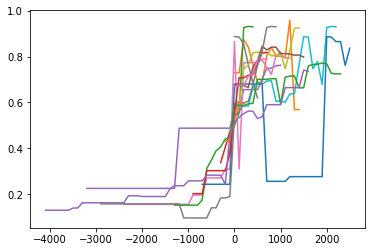

In [51]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

# Redo the RelTime Analysis with this Data?

## Fitting

In [52]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526191e-01  2.04512958e-01  4.20835754e+01 -2.17749689e-02]


In [53]:
# comparison with full data:
Parameters

array([ 5.91641011e-01,  1.93784867e-01,  1.93749271e+01, -1.54321345e-02])

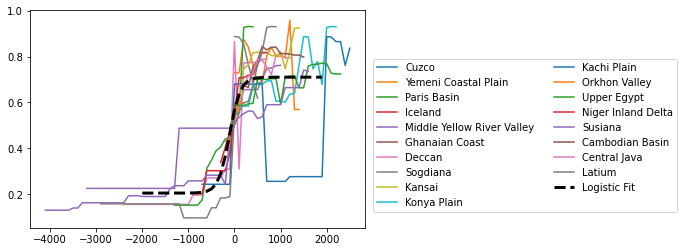

In [54]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Bootstrapping

In [55]:

nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.4436789619235856 0.26243464918573334 110.28288060752807 -0.01614680102777033
-----------------
0.42634730859098213 0.2070451914728146 17.646508438119994 -0.07108094746280888
-----------------
0.5701433656623165 0.19195740223197033 35.86958780422599 -0.019485820315124292
-----------------
0.5098416224826506 0.19004561401695522 52.921072562079424 -0.023101353849322687
-----------------
0.5631870355096409 0.19518877822039332 17.386026997335563 -0.04140161596898483
-----------------
0.5985871796050032 0.19448532984600628 10.041999391342832 -0.08190888820399625
-----------------
0.5510984552337425 0.17276556425132203 33.23101756299516 -0.02475487271481007
-----------------
0.4341841509263782 0.24428992047944437 151.64733507469947 -0.015159393309759163
-----------------
0.5630832117460549 0.205961724877358 32.95455626790397 -0.019767443164710817
-----------------
0.54736814602189 0.20705383682813133 23.001161750389382 -0.034071566488608034
-----------------
0.5748855121756374 0.19104881514

0.41786169117373667 0.20223185030055166 106.06584368870456 -0.017807569114312662
-----------------
0.4992469233432272 0.19146587265274864 28.26784753278283 -0.025009250573910416
-----------------
0.553623080303099 0.22088843365095662 34.40924339336261 -0.01288270369539191
-----------------
0.4774215953015097 0.21533216494585403 72.91383745869624 -0.018323160066148692
-----------------
0.5264568442941779 0.22832684205031836 34.23193831098974 -0.021577202412970335
-----------------
0.5585157012573624 0.20120870613541486 18.411194849862557 -0.030565381514268603
-----------------
0.5005167545696516 0.19903753004547037 41.83161598509002 -0.023633070711596857
-----------------
0.6195372866829574 0.16166872217240436 29.70723191558508 -0.016502989024975795
-----------------
0.49896557730906055 0.20241310517614955 40.66827269600625 -0.021020358604798443
-----------------
0.49108889709302955 0.186431941666417 68.04446640605377 -0.020279004229968742
-----------------
0.46064573624005006 0.2427636

C:\Users\Tobias\AppData\Local\Temp/ipykernel_22808/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5741014598341422 0.1773349766530499 28.71346185261231 -0.022209462397627153
-----------------
0.5707473472141263 0.18025606020431387 26.602404849501887 -0.021556337181278685
-----------------
0.5815589017217062 0.189820913101238 29.056137726985092 -0.020474885534438377
-----------------
0.5056425783435294 0.17440512637025096 92.31067754577705 -0.0168144740042302
-----------------
0.4868752567031499 0.19731265274825815 47.35918447189094 -0.024309136952960973
-----------------
0.43201202512775033 0.21001858355588607 49.61117402311201 -0.02446232728844791
-----------------
0.4759474304291455 0.23843455686808626 32.03384952190084 -0.024145373632488316
-----------------
0.5366478654745714 0.18096082106110462 58.155872201732684 -0.018846105915024225
-----------------
0.5274575281352726 0.18877656245142135 42.78264525189892 -0.015222360231570906
-----------------
0.5008782202028077 0.21376783656620715 16.384892584973258 -0.05498248604545913
-----------------
0.4921073773943539 0.18880349271

0.5402923085252758 0.1825718446469376 39.13800514556768 -0.02531419947162486
-----------------
0.5417792007246949 0.20903012871478355 21.85562613291785 -0.023147364304209904
-----------------
0.5845985508205747 0.21203659449267118 15.635378137128905 -0.027520754992811265
-----------------
0.5082381608754966 0.19953010929655618 59.34247126144229 -0.0175838082143877
-----------------
0.5673650811842926 0.18666263624690504 28.25431134908399 -0.023010731822057144
-----------------
0.5847308645375127 0.20471841160706883 29.55575725198404 -0.015407219059923035
-----------------
0.5915270564222078 0.18405857268680775 36.4336542536103 -0.013354872592855407
-----------------
0.566664873342295 0.22420868162097563 20.249349042739663 -0.02269341698385785
-----------------
0.48767927744482165 0.20868144351008533 32.52249589562335 -0.029290239825178407
-----------------
0.4474701155078605 0.21330608593665476 68.73446863986229 -0.02318881383670037
-----------------
0.609193682860765 0.159857876305279

0.5489511001794037 0.1825588079010217 35.599601691641816 -0.02618134215837318
-----------------
0.5147740778106489 0.18614894586697436 80.18033021171291 -0.016332710000622197
-----------------
0.5153739025900141 0.23213129033392912 35.64478038011717 -0.020535728846259874
-----------------
0.5738351316484213 0.2176348151923304 19.687376268472086 -0.025937235776929142
-----------------
0.48665207026706175 0.23300707149400918 57.95930202251339 -0.014652754238986805
-----------------
0.581363479671577 0.19412588476316012 12.813339212170817 -0.03989324505978214
-----------------
0.5566907710341991 0.19297763142859467 16.738404118966603 -0.030953704930254722
-----------------
0.5215375332305815 0.2033306498843105 40.1964963025486 -0.012866596219728039
-----------------
0.46569473059813776 0.19835867187491552 68.36084980700322 -0.022365685624283576
-----------------
0.5891134616091895 0.1873241653374143 22.091776178311445 -0.017025516739670978
-----------------
0.5485405604777048 0.1729418562

0.5534498549738749 0.18684682802419794 32.50059268327173 -0.01808329691581878
-----------------
0.512130710967598 0.20963541157858298 45.40261286878977 -0.017848048474946306
-----------------
0.5520378219683534 0.2051476062894259 20.197263148663733 -0.04074858610977986
-----------------
0.5809191110787821 0.18788190036333247 20.978989256585614 -0.020066984517748642
-----------------
0.3670810924116993 0.3133221850438032 110.7185845924395 -0.01497917550327267
-----------------
0.5383502556223724 0.1659539097665621 67.39830787420267 -0.017668835290830815
-----------------
0.5746911701408867 0.23277079711816104 18.40266493899624 -0.018211911176923192
-----------------
0.5726857775179998 0.19621098823454633 30.748166743613577 -0.014088436689049414
-----------------
0.49476976461803507 0.2059906727016007 56.435774234923926 -0.017524915341637227
-----------------
0.3940471948253861 0.23733116715008049 83.98819717696898 -0.02296510639948106
-----------------
0.47231627788794145 0.212305368235

0.5368052598959115 0.18081462399717207 41.768971261947826 -0.025243421410561757
-----------------
0.5370609711131301 0.18794274193236074 31.322105365749014 -0.018457853091623268
-----------------
0.4784807711297148 0.22660805059002911 51.42253743818316 -0.018810305910633405
-----------------
0.4694036278507153 0.1851755655502957 83.70529724254828 -0.020786426128565287
-----------------
0.43241247008424216 0.21766306190642348 69.06070912588292 -0.017795195618016894
-----------------
0.5948149477709233 0.17298595401334263 11.89636119960032 -0.02934844251202106
-----------------
0.3991595202077666 0.24836010578753828 828.8816832989866 -0.01869815151413805
-----------------
0.4292992732336697 0.24004053419562932 77.25484364241322 -0.018817629607074542
-----------------
0.5078203021802215 0.24266184200639077 20.48516167585279 -0.03357260747040736
-----------------
0.5071139986044753 0.20681660533811205 33.04985259388849 -0.01816970456114669
-----------------
0.523452771280263 0.184446473401

0.5093326043637396 0.1978432536312777 38.91689094822105 -0.022190525958764293
-----------------
0.6204889737594625 0.15520349776670578 47.464598920588855 -0.01960717259144293
-----------------
0.5150887454237812 0.19161512898258895 44.07908566263185 -0.025931102447255605
-----------------
0.5322979116674421 0.20599235633206656 23.84766940483533 -0.031238570305428794
-----------------
0.5730595563210952 0.1907573470754252 27.54824746751263 -0.013102122473386829
-----------------
0.4773288344403505 0.18112743052001762 164.15653949232714 -0.015482187666971261
-----------------
0.5800838554681453 0.18438353302690155 34.32742140529831 -0.017928165534970994
-----------------
0.5173505566478559 0.17128069148232883 35.255074171729646 -0.014231493078845091
-----------------
0.5803883900364873 0.16900567877093017 33.33947101918577 -0.023407647495471005
-----------------
0.5909925872319561 0.19471718549829192 22.171513709249698 -0.02261689748657376
-----------------
0.5073657115473219 0.184789293

0.5180656981250112 0.17934951339756106 55.25492363436742 -0.02132814523736011
-----------------
0.4864149092282304 0.22601270756745126 39.75567017828852 -0.02565991228926832
-----------------
0.5423545784952869 0.1725780087494982 37.06200588577621 -0.02584064577964156
-----------------
0.6137975468891891 0.182164075057496 26.75101845098334 -0.009751781733449084
-----------------
0.4887670172725172 0.23516906839305082 45.0531385230896 -0.016888115243479256
-----------------
0.4737327799953519 0.18924132068008598 46.63390057034815 -0.024760505707471833
-----------------
0.5306104673754758 0.23953345418245803 24.465430101788524 -0.027234958165754105
-----------------
0.4505928149390095 0.19350837860783363 84.46883790812967 -0.0221568314106305
-----------------
0.5576926624636229 0.20378216369305444 23.720591412631407 -0.02691300052007571
-----------------
0.6093791456500514 0.200095037931039 10.714052802560404 -0.03851287255057473
-----------------
0.5263895036197477 0.19287283036886133 4

0.5734766154297447 0.19514915959070261 17.09979076812644 -0.027815609478740053
-----------------
0.5886545886533192 0.19209974822402193 18.903617623718723 -0.016935430229715245
-----------------
0.5796636666910558 0.19143249413782742 35.15118055116712 -0.014997937180184953
-----------------
0.501617970850299 0.24614194283865354 40.27332565724986 -0.017106979842077406
-----------------
0.500972876140589 0.20491201883991947 29.040657350864095 -0.031330145642898426
-----------------
0.5143832304716309 0.17863490086879927 40.60322512554798 -0.026887921422495773
-----------------
0.472020279891455 0.20216323577044779 46.914143337918645 -0.022728955994468558
-----------------
0.5647819043490251 0.2031830397511979 21.77613362401257 -0.019426263368396774
-----------------
0.4777481764726745 0.18267543096553482 122.29219957844273 -0.017155489111577195
-----------------
0.5449463290523462 0.22346142373697928 18.956757346728757 -0.025858374088838638
-----------------
0.5599077821939952 0.16680708

0.4816432045487906 0.2130961547243059 45.816292848464265 -0.025647036190150477
-----------------
0.5975554842971057 0.17276374600428956 25.226743004608036 -0.019839357282462156
-----------------
0.3964580349447485 0.27280791881384747 100.34552652502126 -0.014338421325610497
-----------------
0.5591527163151577 0.16410887966533425 28.97465456758829 -0.029087708358622805
-----------------
0.5662183086026515 0.19185845578134797 27.540091564093995 -0.017363274327212026
-----------------
0.48992299365511904 0.1897086086720605 52.51248129204005 -0.02471262380537217
-----------------
0.5697755755203766 0.17465916718936897 44.2656838700085 -0.01875618936121808
-----------------
0.595592986671669 0.15810901896233215 46.83962984518259 -0.013539581874394004
-----------------
0.4849279106758588 0.2155219837721266 54.331797277796895 -0.021036641882428167
-----------------
0.5770022819175752 0.20168399747641208 28.889460704103037 -0.018993452900566334
-----------------
0.5563141839240384 0.198975395

0.5986695229827532 0.16712090956347242 38.992496256074205 -0.01214729765308952
-----------------
0.5370703709697304 0.18022556762692424 17.823916834872193 -0.04018171594522868
-----------------
0.5092422266098209 0.20726619173261346 41.605877743542145 -0.016282895232883274
-----------------
0.4973611816311026 0.1988117008174178 85.65186257052635 -0.018682556152654402
-----------------
0.5681104164137076 0.18517482468785187 31.170962002258864 -0.019131490643560126
-----------------
0.5033068053879176 0.21359356603725382 28.075207760410045 -0.025007185619629852
-----------------
0.5702947592205385 0.16153450990060467 33.61542187174955 -0.022292510370803938
-----------------
0.5387062482163429 0.18028751641170776 52.11926775639746 -0.024432991838634614
-----------------
0.40429733487703035 0.24386831898990682 117.12224630450474 -0.015574217264834609
-----------------
0.5072950704919331 0.21123166380156197 21.24957993815746 -0.034509226233001386
-----------------
0.5381272435839715 0.18843

In [56]:
print(negCcount)

0


In [57]:
Params

,a,b,c,d
0,0.443679,0.262435,110.282881,-0.016147
0,0.426347,0.207045,17.646508,-0.071081
0,0.570143,0.191957,35.869588,-0.019486
0,0.509842,0.190046,52.921073,-0.023101
0,0.563187,0.195189,17.386027,-0.041402
...,...,...,...,...
0,0.601784,0.195006,28.752208,-0.009749
0,0.450357,0.224299,130.667409,-0.017310
0,0.416826,0.251658,55.558602,-0.019802
0,0.555105,0.167099,33.070184,-0.025826


50% centred quantiles 0.47968851003904245 0.5629963986701864
90% centred quantiles 0.42336818103694385 0.5967026090685282


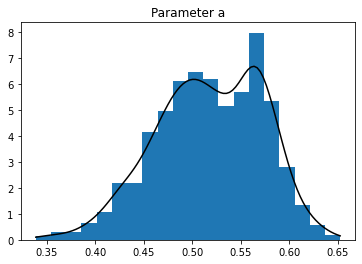

50% centred quantiles 0.1831126670754296 0.21498122887534468
90% centred quantiles 0.16566306204550366 0.24559165314507136


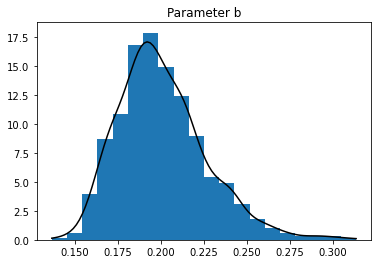

50% centred quantiles 28.73708632422491 56.44243842003641
90% centred quantiles 18.131203974006233 142.3991243520295


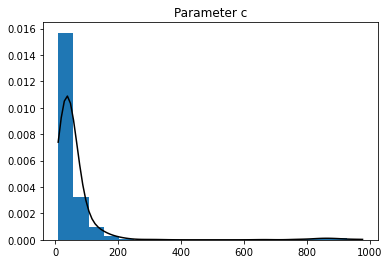

50% centred quantiles -0.024930897909957 -0.017469729206241024
90% centred quantiles -0.03531562174521552 -0.01353653326308336


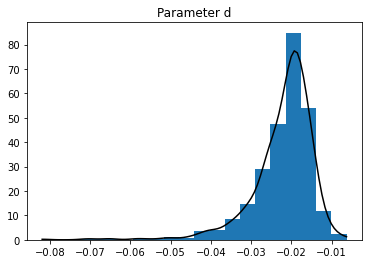

In [58]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [59]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(28.73708632422491, 56.44243842003641)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


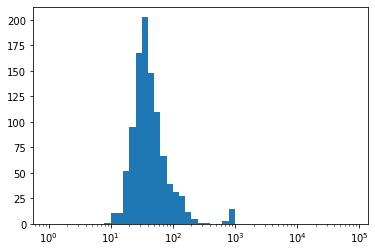

In [60]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [61]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20070168987581738 0.02565106566565899
0.7183444364831698 0.04166650822918337
0.22635275554147638 0.6766779282539864


C:\Users\Tobias\AppData\Local\Temp/ipykernel_22808/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [62]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1270.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [63]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [64]:
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.48216696536794684 0.20785626647016253 49.55285112433071 -0.021837354737051482     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.75746673e-11])
       r: array([-0.88139696])
  status: 1
 success: True
       x: array([-0.08685063])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.60216285e-12])
       r: array([-0.64299428])
  status: 1
 success: True
       x: array([0.04998612])
-----------------
0.5565148440959532 0.17642753964640226 33.88680312238535 -0.017018851545613944     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.8164914e-12])
       r: array([-1.54003359])
  status: 1
 success: True
       x: array([-0.08539872])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.99293964e-12])
       r: array

C:\Users\Tobias\AppData\Local\Temp/ipykernel_22808/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5521009004352679 0.19706269284902972 27.690594762582485 -0.02918416150273142     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.04084013e-11])
       r: array([-0.76803316])
  status: 1
 success: True
       x: array([-0.13326179])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.10967568e-10])
       r: array([-1.74364473])
  status: 1
 success: True
       x: array([0.03905545])
-----------------
0.5303351162079732 0.1780874181259411 31.443395948321317 -0.03337221586587901     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.48363568e-13])
       r: array([-1.37950842])
  status: 1
 success: True
       x: array([-0.10656327])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.08801856e-14])
  

       x: array([0.20759497])
-----------------
0.5002770596835816 0.2021843334258354 20.168904346159312 -0.0396952439194109     fjac: array([[-1.]])
     fun: array([3.60822483e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-9.06483777e-11])
       r: array([-0.46390365])
  status: 1
 success: True
       x: array([-0.18747715])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.83519866e-13])
       r: array([-0.49322299])
  status: 1
 success: True
       x: array([0.10471095])
-----------------
0.47932156947769894 0.21900751627417275 40.84526920902449 -0.028050047422447093     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.87153634e-12])
       r: array([-0.29542102])
  status: 1
 success: True
       x: array([-0.12996825])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 1

0.5679753112998377 0.18672692193146845 21.363074947430665 -0.024715407267248406     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.50751666e-11])
       r: array([-0.78747157])
  status: 1
 success: True
       x: array([-0.14596559])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.60791388e-13])
       r: array([-1.43786082])
  status: 1
 success: True
       x: array([0.06128743])
-----------------
0.5013599913771569 0.19307080212614927 51.817228284330675 -0.02053198234968583     fjac: array([[-1.]])
     fun: array([-8.32667268e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.64896763e-10])
       r: array([-1.61008723])
  status: 1
 success: True
       x: array([-0.07155014])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([4.02855527e-12]

0.5783037692904548 0.18148463768291517 28.657214262250655 -0.014444279908217485     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.72242784e-11])
       r: array([-1.18603717])
  status: 1
 success: True
       x: array([-0.10083129])     fjac: array([[-1.]])
     fun: array([1.55431223e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([3.85325216e-10])
       r: array([-2.03941996])
  status: 1
 success: True
       x: array([0.04783593])
-----------------
0.5062079506090393 0.2084464245798424 35.032767166052075 -0.020699859763412074     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-9.00945984e-14])
       r: array([-0.60511829])
  status: 1
 success: True
       x: array([-0.11506234])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.33502098e-11])
       r: array([-1.2306

0.49021564250231864 0.2161616267047772 30.73427510535683 -0.03673905802946444     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.48061596e-13])
       r: array([-0.30670555])
  status: 1
 success: True
       x: array([-0.16208184])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.34336986e-14])
       r: array([-0.85748724])
  status: 1
 success: True
       x: array([0.05245203])
-----------------
0.5095653204679105 0.2019405928178129 71.71288667302318 -0.016156066077186063     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.38455913e-12])
       r: array([-1.66679551])
  status: 1
 success: True
       x: array([-0.0578415])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-1.27131639e-12])
       r: array([-2.3269

0.5221791272433126 0.18227416129815735 78.44789766678792 -0.017204541142704203     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.34621783e-11])
       r: array([-3.16598968])
  status: 1
 success: True
       x: array([-0.04759218])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([-2.57571742e-14])
       r: array([-2.06301908])
  status: 1
 success: True
       x: array([0.01949757])
-----------------
0.6130994149564438 0.18322374612794712 30.36156373223778 -0.012002709809345024     fjac: array([[-1.]])
     fun: array([3.83026943e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-3.99519862e-10])
       r: array([-1.21736038])
  status: 1
 success: True
       x: array([-0.09702431])     fjac: array([[-1.]])
     fun: array([1.55431223e-15])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([4.29242752e-10])


0.4766928931129433 0.21602994325661 52.70200438613202 -0.017954390112273667     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.05526698e-13])
       r: array([-0.53225189])
  status: 1
 success: True
       x: array([-0.09025948])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([4.71744865e-12])
       r: array([-0.81713629])
  status: 1
 success: True
       x: array([0.04574798])
-----------------
0.48400104823603846 0.20116536864030904 76.45377552518035 -0.020121206029006806     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.81815682e-11])
       r: array([-1.82545601])
  status: 1
 success: True
       x: array([-0.05808272])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 35
     qtf: array([-9.0405

       x: array([0.02381569])
-----------------
0.568151812906745 0.20043823771086855 34.71693104689397 -0.01908482075424875     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.68305386e-12])
       r: array([-0.85863718])
  status: 1
 success: True
       x: array([-0.1066761])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-3.07531778e-14])
       r: array([-2.67470143])
  status: 1
 success: True
       x: array([0.02830094])
-----------------
0.5365449766346537 0.1928887741594695 33.491949331916 -0.01513048657482248     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-6.43463061e-12])
       r: array([-1.05087297])
  status: 1
 success: True
       x: array([-0.09605386])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     

0.5022064067740623 0.19517888471920947 60.55187990811643 -0.01856135293789903     fjac: array([[-1.]])
     fun: array([-2.55351296e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.53717972e-10])
       r: array([-1.77047642])
  status: 1
 success: True
       x: array([-0.06340467])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([1.63857816e-12])
       r: array([-1.20216881])
  status: 1
 success: True
       x: array([0.03340095])
-----------------
0.5651047074643566 0.20768902884355553 25.826609618918607 -0.017893589196056655     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-7.04436509e-13])
       r: array([-0.46610118])
  status: 1
 success: True
       x: array([-0.14864418])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.25578214e-10])


       x: array([0.02700729])
-----------------
0.5464512866715563 0.21378602593433396 19.381251018603624 -0.026456293804060962     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.58029717e-11])
       r: array([-0.23795862])
  status: 1
 success: True
       x: array([-0.2198972])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.86779481e-11])
       r: array([-1.3718462])
  status: 1
 success: True
       x: array([0.06187319])
-----------------
0.5736159460416039 0.19665298494804528 22.782691701825943 -0.03485388493617527     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.65795155e-12])
       r: array([-0.64160688])
  status: 1
 success: True
       x: array([-0.16247953])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 1

0.5619689160073021 0.21992500803785828 17.258664562885084 -0.028410842988951093     fjac: array([[-1.]])
     fun: array([2.08166817e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.59808333e-10])
       r: array([-0.1096669])
  status: 1
 success: True
       x: array([-0.28679228])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-5.02153874e-13])
       r: array([-1.4759037])
  status: 1
 success: True
       x: array([0.05665525])
-----------------
0.4842523701579873 0.20527715967332177 13.735778176189939 -0.08284737453700189     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-9.16708376e-12])
       r: array([-0.27689085])
  status: 1
 success: True
       x: array([-0.30780682])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.0832229e-14])
       r: arra

0.5266866633458656 0.16660007752960942 54.94637429497731 -0.01917428088694635     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([5.73430192e-14])
       r: array([-2.91071432])
  status: 1
 success: True
       x: array([-0.05659211])     fjac: array([[-1.]])
     fun: array([2.77555756e-15])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([2.72854295e-10])
       r: array([-0.88380647])
  status: 1
 success: True
       x: array([0.04315249])
-----------------
0.5528071097908892 0.21787216891956493 24.01627991962509 -0.02078317998484878     fjac: array([[-1.]])
     fun: array([5.27355937e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-7.54940555e-11])
       r: array([-0.20054898])
  status: 1
 success: True
       x: array([-0.1940727])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.16334

0.5711933837136332 0.15867165253429882 46.25737673287399 -0.01999713921785994     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.90274488e-13])
       r: array([-2.7597857])
  status: 1
 success: True
       x: array([-0.06338051])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-1.37667655e-14])
       r: array([-2.23120385])
  status: 1
 success: True
       x: array([0.02920953])
-----------------
0.45219925318795473 0.22613657116057861 44.7983859973237 -0.02033446186026175     fjac: array([[-1.]])
     fun: array([8.32667268e-17])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-4.94812524e-12])
       r: array([-0.0096802])
  status: 1
 success: True
       x: array([-0.19099392])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([1.74652515e-11])
       r: array(

0.5766395421023695 0.17369585113023706 22.498434912527276 -0.028320887447548206     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.22762911e-13])
       r: array([-1.07651509])
  status: 1
 success: True
       x: array([-0.13044627])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.00908171e-12])
       r: array([-1.44549674])
  status: 1
 success: True
       x: array([0.05706857])
-----------------
0.5115558574271147 0.18665619862800842 51.38978477306382 -0.02755986351654316     fjac: array([[-1.]])
     fun: array([-6.66133815e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.68779463e-10])
       r: array([-1.88170179])
  status: 1
 success: True
       x: array([-0.07572929])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([6.65133504e-11])


0.5050634152030586 0.19549074762683566 52.50076085115517 -0.018996770985312657     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.9817481e-14])
       r: array([-1.52127145])
  status: 1
 success: True
       x: array([-0.07103614])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-4.36906067e-12])
       r: array([-1.19426257])
  status: 1
 success: True
       x: array([0.0382095])
-----------------
0.46820040458142614 0.21799276826361105 68.55474903032662 -0.02019356107800456     fjac: array([[-1.]])
     fun: array([-4.16333634e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-6.3708927e-11])
       r: array([-0.56287971])
  status: 1
 success: True
       x: array([-0.07864936])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([-2.2361335e-11])
       r: arra

0.519879373718099 0.180749029104056 35.403987273794925 -0.02462339552661812     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-5.52712875e-11])
       r: array([-1.47292299])
  status: 1
 success: True
       x: array([-0.09076847])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([-1.74860126e-13])
       r: array([-0.80887814])
  status: 1
 success: True
       x: array([0.06097274])
-----------------
0.5549936443657492 0.19640780660295734 21.93238796481553 -0.021640613531514943     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.36557432e-14])
       r: array([-0.62132823])
  status: 1
 success: True
       x: array([-0.15222969])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-7.24864613e-13])
       r: array([-1.41821

0.5248483063259628 0.1933125928120074 38.50385928159825 -0.02337199774090642     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-7.89368571e-14])
       r: array([-1.19208806])
  status: 1
 success: True
       x: array([-0.09350431])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-1.77635684e-14])
       r: array([-1.47101062])
  status: 1
 success: True
       x: array([0.04040056])
-----------------
0.47604695609533987 0.2154065278696352 39.34932871200216 -0.023168685969675987     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.2827267e-11])
       r: array([-0.42082338])
  status: 1
 success: True
       x: array([-0.11845009])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-7.23865412e-14])
  

       x: array([0.08806105])
-----------------
0.5465649222029364 0.18409097993682264 35.91881920094366 -0.01773462979372817     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.47648601e-13])
       r: array([-1.40061822])
  status: 1
 success: True
       x: array([-0.08675958])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([5.32907052e-15])
       r: array([-1.74734952])
  status: 1
 success: True
       x: array([0.04382349])
-----------------
0.5880283096377101 0.20402303255074117 14.992063919241767 -0.033801003341212846     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-8.41049452e-13])
       r: array([-0.32205624])
  status: 1
 success: True
       x: array([-0.24939125])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: a

0.517127583792036 0.18021916133087765 32.56166863413094 -0.03389532684852663     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.53488333e-13])
       r: array([-1.36817493])
  status: 1
 success: True
       x: array([-0.10524621])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.49069646e-12])
       r: array([-0.64611158])
  status: 1
 success: True
       x: array([0.06373094])
-----------------
0.4845970687501431 0.20351513134178809 40.50508796046745 -0.02603371574536314     fjac: array([[-1.]])
     fun: array([6.9388939e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.46558932e-10])
       r: array([-0.88144978])
  status: 1
 success: True
       x: array([-0.10026228])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-4.88498131e-15])
   

0.5906274556463653 0.21482606481622135 24.01160365322873 -0.01476679880986689     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.80803159e-13])
       r: array([-0.27137285])
  status: 1
 success: True
       x: array([-0.1778884])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.60691468e-12])
       r: array([-2.4179301])
  status: 1
 success: True
       x: array([0.03842302])
-----------------
0.5714351215285751 0.1760747511367641 50.05936424445823 -0.01919729688939595     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.07285317e-13])
       r: array([-2.29543575])
  status: 1
 success: True
       x: array([-0.06591151])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-2.85371726e-12])
       r: array([-3.10628467

       x: array([0.09299071])
-----------------
0.5575045166260221 0.19999540477500471 17.998603533040455 -0.03483772551694412     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.89847416e-10])
       r: array([-0.45197])
  status: 1
 success: True
       x: array([-0.20170022])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.47912801e-13])
       r: array([-1.24379621])
  status: 1
 success: True
       x: array([0.0637589])
-----------------
0.5240839208929899 0.17033662520199805 51.761667224173635 -0.018730772686010654     fjac: array([[-1.]])
     fun: array([-1.22124533e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.61647898e-10])
       r: array([-2.58956752])
  status: 1
 success: True
       x: array([-0.05974517])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'

0.6116407700954749 0.15547016512464745 31.19925678637912 -0.01854132332867688     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.48476803e-12])
       r: array([-1.95519743])
  status: 1
 success: True
       x: array([-0.08366939])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([6.55031585e-15])
       r: array([-2.4042835])
  status: 1
 success: True
       x: array([0.0375991])
-----------------
0.538051816852238 0.1757354174913316 57.039031158138556 -0.01958685593508576     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.45113668e-11])
       r: array([-2.61554951])
  status: 1
 success: True
       x: array([-0.05929408])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-2.37476705e-12])
       r: array([-1

0.4649636153645891 0.21355958673286046 26.86039158834252 -0.03570852496092486     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.29298827e-14])
       r: array([-0.3341748])
  status: 1
 success: True
       x: array([-0.16843734])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.56301663e-14])
       r: array([-0.04936807])
  status: 1
 success: True
       x: array([0.16999789])
-----------------
0.5414078419721939 0.2214111697927462 24.836611563421076 -0.0186940460221802     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.40354395e-12])
       r: array([-0.12161213])
  status: 1
 success: True
       x: array([-0.20742017])     fjac: array([[-1.]])
     fun: array([1.11022302e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.175048e-10])
       r: array([-

0.5872908562661224 0.19032690746409867 11.488983105717582 -0.03954798125444783     fjac: array([[-1.]])
     fun: array([6.66133815e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.55510244e-10])
       r: array([-0.38851236])
  status: 1
 success: True
       x: array([-0.27699101])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.47468712e-13])
       r: array([-0.96037481])
  status: 1
 success: True
       x: array([0.09731409])
-----------------
0.5534050992468027 0.21301467154957593 19.286879647007527 -0.029454438195656223     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.52275986e-11])
       r: array([-0.25105062])
  status: 1
 success: True
       x: array([-0.22135017])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-4.33031389e-12]

0.5420703050391658 0.1821273364458112 41.70683498177126 -0.014250927455260754     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.23003846e-11])
       r: array([-1.69401867])
  status: 1
 success: True
       x: array([-0.0722987])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.91152649e-11])
       r: array([-1.80815878])
  status: 1
 success: True
       x: array([0.04191504])
-----------------
0.5557851065627102 0.2215789755292931 20.377441670363787 -0.02633119285886359     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.90125693e-14])
       r: array([-0.09644189])
  status: 1
 success: True
       x: array([-0.25936422])     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.90137581e-10])


       x: array([0.07397261])
-----------------
0.4908908616615474 0.22128696024517966 36.107239142511936 -0.034448022060718786     fjac: array([[-1.]])
     fun: array([1.38777878e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.13818344e-10])
       r: array([-0.1810265])
  status: 1
 success: True
       x: array([-0.16083092])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.68337122e-10])
       r: array([-1.18910443])
  status: 1
 success: True
       x: array([0.03621998])
-----------------
0.58244600066482 0.2000666815814803 25.12799534737064 -0.011876000534822595     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.13526696e-11])
       r: array([-0.63070786])
  status: 1
 success: True
       x: array([-0.13333482])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
 

0.5511418912604201 0.17183842353628753 37.51114570563888 -0.016549744714471872     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.98982497e-11])
       r: array([-1.84262959])
  status: 1
 success: True
       x: array([-0.07544895])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.1056811e-10])
       r: array([-1.5909344])
  status: 1
 success: True
       x: array([0.04713925])
-----------------
0.533340507415931 0.19821472337837165 56.03553526425736 -0.016365101773428644     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.86234925e-12])
       r: array([-1.4935438])
  status: 1
 success: True
       x: array([-0.06790092])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-2.11941575e-13])
       r: array([-

0.4936348296973545 0.1991571060832867 35.97077288684181 -0.021938852060926762     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.68021042e-10])
       r: array([-0.9243585])
  status: 1
 success: True
       x: array([-0.1009494])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-2.44249065e-14])
       r: array([-0.56071195])
  status: 1
 success: True
       x: array([0.07227427])
-----------------
0.5972537463306029 0.1615263114118735 26.870100867398797 -0.03548590586691884     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.85875482e-11])
       r: array([-1.55282775])
  status: 1
 success: True
       x: array([-0.11385304])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.47727394e-11])
       r: array

0.5928784143397952 0.17124189439641618 34.840339733863566 -0.018732642228647105     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.42218459e-11])
       r: array([-1.74160181])
  status: 1
 success: True
       x: array([-0.0841189])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-5.25135491e-14])
       r: array([-2.59719718])
  status: 1
 success: True
       x: array([0.03162397])
-----------------
0.5325567158849859 0.17461898132419945 49.05068590176402 -0.022807578982646272     fjac: array([[-1.]])
     fun: array([-4.52415883e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.66931724e-10])
       r: array([-2.29105289])
  status: 1
 success: True
       x: array([-0.06825828])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([7.0

0.5638036710484147 0.18687721208189265 26.89576479424269 -0.01703871427274573     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.81873413e-11])
       r: array([-0.98738814])
  status: 1
 success: True
       x: array([-0.11320391])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-6.71129818e-12])
       r: array([-1.72911674])
  status: 1
 success: True
       x: array([0.05322862])
-----------------
0.5054522176681626 0.21191088706129615 41.28307120648805 -0.020644499012227688     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.37098666e-11])
       r: array([-0.57917086])
  status: 1
 success: True
       x: array([-0.10606289])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-9.7221009e-11])
       r: arr

0.5023282356369955 0.20497547793650098 45.119172040998066 -0.018334332794778693     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.28678229e-12])
       r: array([-0.92347923])
  status: 1
 success: True
       x: array([-0.08733907])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-8.0624396e-13])
       r: array([-1.29756456])
  status: 1
 success: True
       x: array([0.04227197])
-----------------
0.5231883562995152 0.19999110703732914 43.03301260965363 -0.015389294111362186     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.0463852e-14])
       r: array([-1.07726157])
  status: 1
 success: True
       x: array([-0.08362368])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([7.70572495e-12])
       r: array([-1.8232400

0.4977107924417705 0.19845561882356488 60.27004279105092 -0.021018628171121725     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.76865206e-12])
       r: array([-1.58711903])
  status: 1
 success: True
       x: array([-0.06787129])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-1.80524484e-11])
       r: array([-1.12858168])
  status: 1
 success: True
       x: array([0.03207992])
-----------------
0.5398192540274172 0.1993500216982431 20.246786282868566 -0.03192340965949223     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-9.80579506e-12])
       r: array([-0.51937121])
  status: 1
 success: True
       x: array([-0.17732821])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.02571293e-12])
       r: array([-1.1187

0.579254461196849 0.17991860620783573 24.684187902633752 -0.012583016903240027     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.56228372e-12])
       r: array([-1.05430885])
  status: 1
 success: True
       x: array([-0.11143776])     fjac: array([[-1.]])
     fun: array([2.55351296e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.34057346e-10])
       r: array([-1.7463101])
  status: 1
 success: True
       x: array([0.06015044])
-----------------
0.5493993694171823 0.2227519775299335 23.71623800847019 -0.026273013831927657     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-1.02140518e-13])
       r: array([-0.08483723])
  status: 1
 success: True
       x: array([-0.23798872])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.94844141e-13])
       r: array([-1.870790

0.5198941104429478 0.19056589396777307 33.74114753912588 -0.01717121722274704     fjac: array([[-1.]])
     fun: array([1.94289029e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([5.60170244e-11])
       r: array([-1.12436864])
  status: 1
 success: True
       x: array([-0.09436852])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.18494103e-12])
       r: array([-1.06577999])
  status: 1
 success: True
       x: array([0.06185718])
-----------------
0.5578805875064066 0.18769001584403516 51.65181930933892 -0.01783377739207007     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([7.18730631e-13])
       r: array([-1.85860316])
  status: 1
 success: True
       x: array([-0.0681214])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([2.43816078e-12])
      

       x: array([0.04555029])
-----------------
0.5453814823594053 0.2176490308048171 17.82755091678402 -0.028537503043119306     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.05204734e-12])
       r: array([-0.15268988])
  status: 1
 success: True
       x: array([-0.25973285])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.56108459e-12])
       r: array([-1.29570675])
  status: 1
 success: True
       x: array([0.06517556])
-----------------
0.5394960232865149 0.19463723954990325 41.30525412393527 -0.017121545844637102     fjac: array([[-1.]])
     fun: array([-9.99200722e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.84943644e-10])
       r: array([-1.23301169])
  status: 1
 success: True
       x: array([-0.08426175])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: a

0.49682917587018127 0.21372536253571786 28.752444681718444 -0.024284802130645603     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.21247751e-11])
       r: array([-0.3538418])
  status: 1
 success: True
       x: array([-0.15111343])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.88404847e-13])
       r: array([-0.90762009])
  status: 1
 success: True
       x: array([0.0666605])
-----------------
0.5151654119433392 0.17790492401497746 60.03970320408314 -0.022289977084145082     fjac: array([[-1.]])
     fun: array([2.49800181e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([9.32210975e-11])
       r: array([-2.63523471])
  status: 1
 success: True
       x: array([-0.06001896])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([5.70721248e-12])


0.555334497827885 0.17916030173552927 17.251362187142494 -0.0371970244385643     fjac: array([[-1.]])
     fun: array([6.18949336e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.05227432e-10])
       r: array([-0.74495534])
  status: 1
 success: True
       x: array([-0.17495583])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.45561341e-12])
       r: array([-0.89357647])
  status: 1
 success: True
       x: array([0.08756706])
-----------------
0.5258205530298251 0.18086385051998247 48.24795445902261 -0.019879516092953284     fjac: array([[-1.]])
     fun: array([-1.44328993e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.65494293e-10])
       r: array([-2.00486747])
  status: 1
 success: True
       x: array([-0.0687315])     fjac: array([[-1.]])
     fun: array([2.33146835e-15])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-3.2161

0.5461699809282792 0.18933596666261385 31.809835605600107 -0.02409437192497336     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-7.79321052e-13])
       r: array([-1.09769298])
  status: 1
 success: True
       x: array([-0.10650213])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.36157793e-14])
       r: array([-1.66975073])
  status: 1
 success: True
       x: array([0.04237399])
-----------------
0.5604908358479463 0.1988576693698355 29.749507106600724 -0.015029241381058836     fjac: array([[-1.]])
     fun: array([2.44249065e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.04896636e-10])
       r: array([-0.77784593])
  status: 1
 success: True
       x: array([-0.11467816])     fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.91176075e-10])
  

0.46940588675071604 0.22519593880650768 89.66429300743225 -0.017418758874499545     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.13558077e-15])
       r: array([-0.10346952])
  status: 1
 success: True
       x: array([-0.08437215])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 36
     qtf: array([-3.03000958e-11])
       r: array([-1.54576997])
  status: 1
 success: True
       x: array([0.01856436])
-----------------
0.49311328183246916 0.20637310531558392 22.2938583067548 -0.045119359428951664     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.07056594e-14])
       r: array([-0.42737611])
  status: 1
 success: True
       x: array([-0.18707162])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.62103664e-12])
       r: array([-0.48

In [65]:
print(Successes)
print(Params2.round(2))

707
       a     b      c     d    T1    T2
0   0.48  0.21  49.55 -0.02 -0.09  0.05
0   0.56  0.18  33.89 -0.02 -0.09  0.05
0   0.53  0.19  21.20 -0.03 -0.15  0.08
0   0.55  0.20  27.69 -0.03 -0.13  0.04
0   0.53  0.18  31.44 -0.03 -0.11  0.05
..   ...   ...    ...   ...   ...   ...
0   0.55  0.18  55.53 -0.02 -0.06  0.02
0   0.56  0.17  24.75 -0.03 -0.12  0.06
0   0.50  0.20  29.17 -0.04 -0.14  0.06
0   0.47  0.20  62.68 -0.02 -0.07  0.08
0   0.58  0.22  16.29 -0.02 -0.29  0.06

[707 rows x 6 columns]


In [66]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [67]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
      u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.16713134466354151
Most of the cultural evolution takes place in a time interval of  836.0 ± 397.0 years.


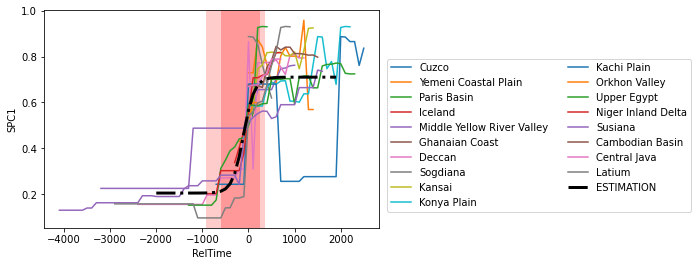

In [68]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()